In [59]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import math
import itertools

## Multivariable

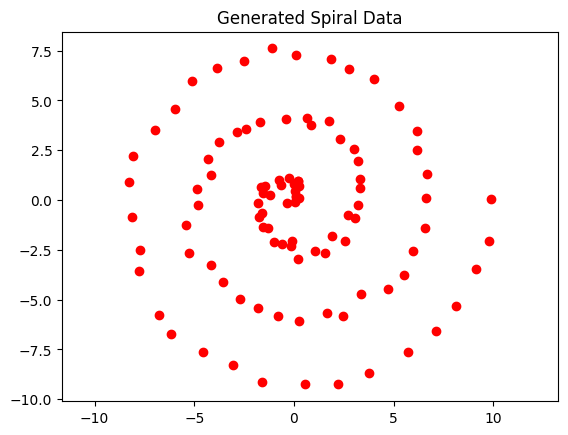

In [60]:
# Parameters for the spiral
num_points = 100  # Number of points
num_turns = 3     # Number of spiral turns
noise = 0.2       # Noise level

# Generate the angles for the spiral
theta = np.linspace(0, num_turns * 2 * np.pi, num_points)

# Generate the radii (distance from origin)
r = np.linspace(0, 10, num_points)

# Convert polar coordinates (r, theta) to Cartesian coordinates (x, y)
x = r * np.cos(theta)
y = r * np.sin(theta)

# Add noise to the data
x += np.random.normal(0, noise, num_points)
y += np.random.normal(0, noise, num_points)

x_0 = np.vstack((x, y)).T

# Plot the spiral
plt.scatter(x, y, color='red')
plt.axis('equal')
plt.title('Generated Spiral Data')
plt.show()

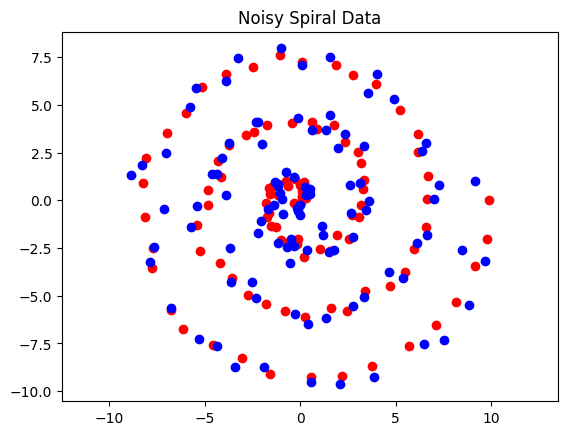

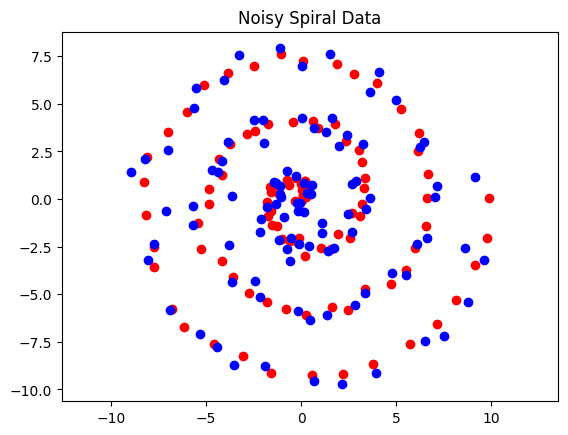

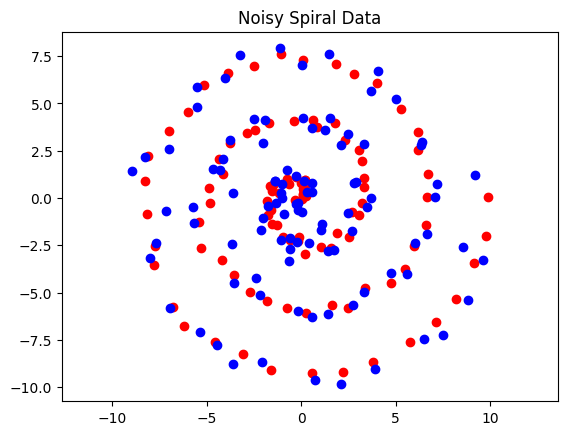

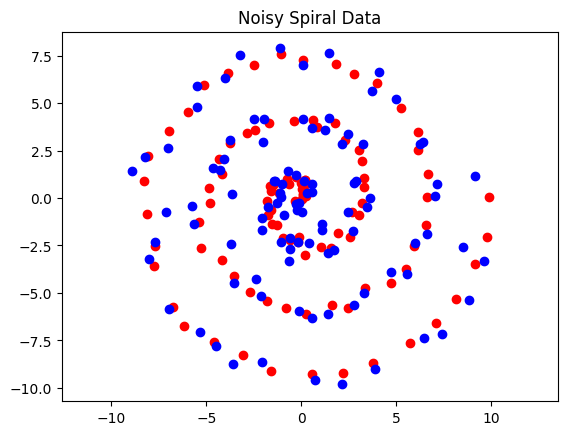

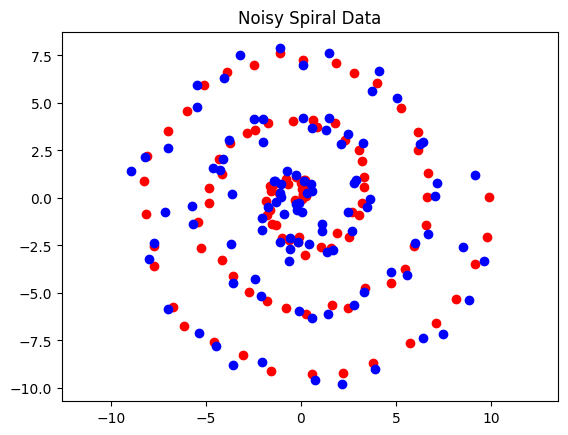

In [61]:
# Add noise to the data
noise_level = [0.5, 0.1, 0.05, 0.03, 0.01]
x = x_0.copy()

training_data = []
label_matrix = []

for epsilon in noise_level:
    gaussian_noise = np.random.multivariate_normal([0, 0], np.eye(2), num_points)
    x += epsilon * gaussian_noise
    label_matrix.append(gaussian_noise)
    training_data.append(x.copy())

    plt.scatter(x_0[:, 0], x_0[:, 1], color='red', label='Original')
    plt.scatter(x[:, 0], x[:, 1], color='blue', label='Noisy')
    plt.axis('equal')
    plt.title('Noisy Spiral Data')
    plt.show()

In [62]:
# Generate 100 2d random points
np.random.seed(0)

N = 100  # number of data samples
D = 2   # dimensions of data
C = math.comb(N, D-1)  # number of combinations of N choose D-1

In [63]:
# find K matrix from the given data, see Theorem F.2
def find_K(x: np.ndarray) -> np.ndarray:
    K = np.zeros((N, C))
    row_idx = np.arange(N)

    # Generate possible combinations of d-1 elements from n elements
    idx_combinations = list(itertools.combinations(row_idx, D-1))

    for i in range(N):
        x_i = x[i]
        for j in range(C):
            x_j = x[idx_combinations[j]]
            
            # Compute outer product of every row in x_j and take L1 norm
            # print("x_i: ",x_i)
            # print("x_j: ", x_j)
            denominator = np.linalg.norm(x_j, ord=1)
            # print("denominator: ", denominator)

            numerator = np.cross(x_i, x_j)
            numerator = np.maximum(numerator, 0)
            # print("numerator: ", numerator)

            K[i, j] = numerator / denominator

    return K

K_list = []
for x in training_data:
    K_list.append(find_K(x))

/tmp/ipykernel_151159/473674103.py:20: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  numerator = np.cross(x_i, x_j)


In [64]:
# Solve Eq 33
Z_list = []

for i in range(len(noise_level)):
    epsilon = noise_level[i]
    # l is label matrix
    # l = label_matrix[i]
    l = np.random.multivariate_normal([0, 0], np.eye(2), C)
    l = l / epsilon

    reg_lambda = 1
    z = cp.Variable((C, D))

    # Define the optimization problem
    regularization_term = reg_lambda * cp.sum([cp.norm(z[:, i], 2) for i in range(D)])
    objective = cp.Minimize(cp.norm(K_list[i].T @ z - l, 'fro')**2 + regularization_term)

    # Solve the optimization problem
    problem = cp.Problem(objective)
    problem.solve(verbose=True, solver='ECOS')

    # Extract the optimal value and optimal Z
    optimal_value = problem.value
    optimal_Z = z.value
    Z_list.append(optimal_Z)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Dec 12 07:15:34 PM: Your problem has 200 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 12 07:15:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 12 07:15:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 12 07:15:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 12 07:15:34 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 12 07:15:34 PM: Compiling problem (target solver=ECOS).
(CV

/home/kanghyunryu/anaconda3/envs/convex/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
/home/kanghyunryu/anaconda3/envs/convex/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [65]:
# Achieve NN
# They fucked up the notation in Eq 34..., 
# We should look Eq 48 of arxiv.org/pdf/2309.16512 
# I'm interpreting Z_j as the j-th row of Z, and x_i x_j as a row in x
def NN(x: np.ndarray, optimal_Z: np.ndarray) -> np.ndarray:
    output = np.zeros_like(x)
    idx_combinations = list(itertools.combinations(np.arange(N), D-1))
    for j in range(C):
        Z_j = optimal_Z[j]
        x_i = x[j]
        x_j = x[idx_combinations[j]]
        
        numerator = np.cross(x_i, x_j)
        numerator = np.maximum(numerator, 0)

        denominator = np.linalg.norm(x_j, ord=1)

        output += Z_j * (numerator / denominator)

    return output


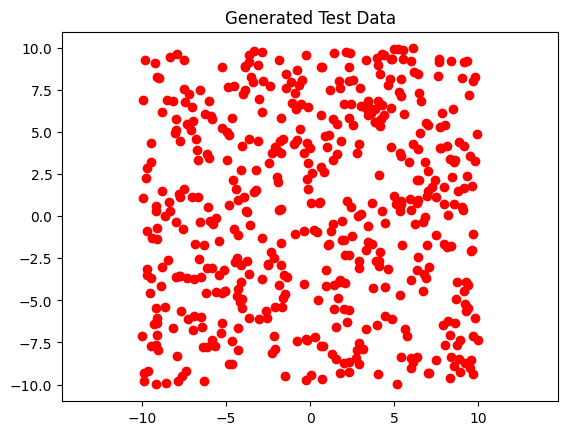

/tmp/ipykernel_151159/3981775102.py:13: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  numerator = np.cross(x_i, x_j)


ValueError: operands could not be broadcast together with shapes (500,2) (100,2) 

In [ ]:
# Sample
x_T = np.random.uniform(-10, 10, (100, 2))

plt.scatter(x_T[:, 0], x_T[:, 1], color='red', label='Original')
plt.axis('equal')
plt.title('Generated Test Data')
plt.show()

steps_per_noise = [5, 5, 5, 5, 15]

x = x_T.copy()
eta = 1

for i in range(5):
    optimal_Z = Z_list[i]
    epsilon = noise_level[i]

    for j in range(steps_per_noise[i]):
        NN_output = NN(x, optimal_Z)
        z_t = np.random.multivariate_normal(mean=np.zeros(2), cov=epsilon*np.eye(D), size=x.shape[0])
        x = x + eta*NN_output + np.sqrt(2*eta)*z_t

    plt.scatter(x[:, 0], x[:, 1], color='blue', label='Diffusion')
    plt.axis('equal')
    plt.title(f'NN with noise level {epsilon}')
    plt.show()